导入相关模块。

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from beautify import (
    enlarge_eyes,
    smooth_skin_bilateral,
    smooth_skin_guided,
    squeeze_face,
    whiten_hsi_clahe,
    whiten_lab_clahe,
    whiten_hsi_gamma,
    whiten_hsi_gain,
    whiten_lab_gain,
)
from blend import blend_image, feather_mask
from calibrate import undistort_image
from detect_face import get_face_mask
from preprocess import gaussian_filter, laplacian_sharpen, median_filter

# 设置中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 黑体
plt.rcParams["axes.unicode_minus"] = False  # 负号正常显示

读取内参矩阵和畸变系数。

In [2]:
params = np.load("../src/calib_params.npz")
K = params["camera_matrix"]
d = params["dist_coeffs"]
print(f"camera_matrix:\n{K}")
print(f"dist_coeffs:\n{d}")

camera_matrix:
[[1.84237531e+03 0.00000000e+00 1.24434538e+03]
 [0.00000000e+00 1.84905329e+03 1.74859952e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_coeffs:
[[ 0.03358079 -0.06483352  0.0004901   0.00100563  0.04323759]]


读取原始图像。

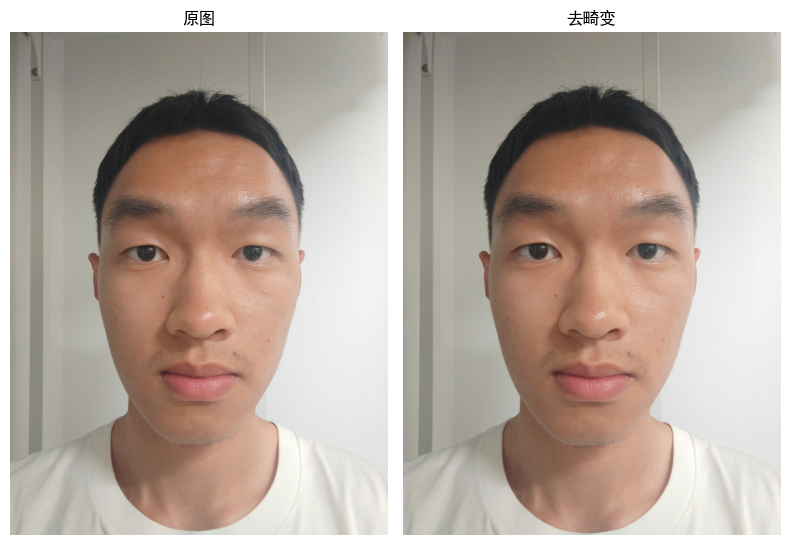

In [3]:
plt.figure(figsize=(8, 6))

img0 = cv2.imread("../images/111.jpg")
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("原图")

img1 = undistort_image(img0, K, d)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("去畸变")

plt.tight_layout()
plt.show()

预处理，中值滤波+高斯滤波+拉普拉斯锐化。

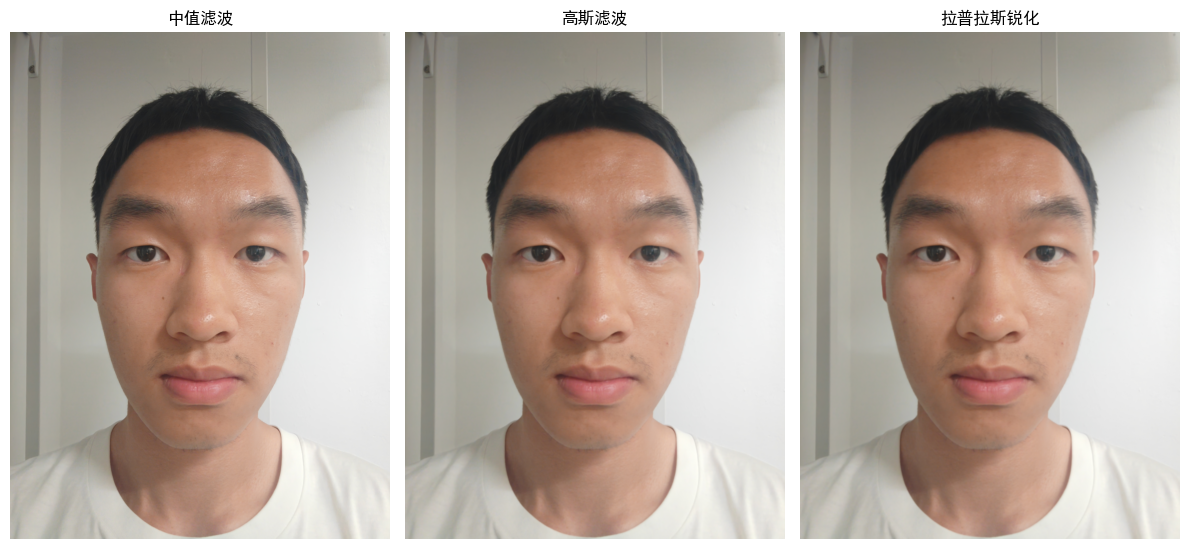

In [4]:
plt.figure(figsize=(12, 6))

img2 = median_filter(img1, k_size=5)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("中值滤波")

img3 = gaussian_filter(img2, k_size=13, sigma=2.0)
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("高斯滤波")

img4 = laplacian_sharpen(img3, alpha=0.8, k_size=1)
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("拉普拉斯锐化")

plt.tight_layout()
plt.show()

人脸区域分割。

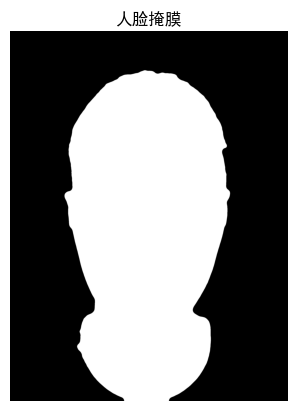

In [5]:
plt.figure()
face_mask = get_face_mask(img4)
plt.imshow(face_mask, cmap="gray")
plt.axis("off")
plt.title("人脸掩膜")
plt.show()

美白。

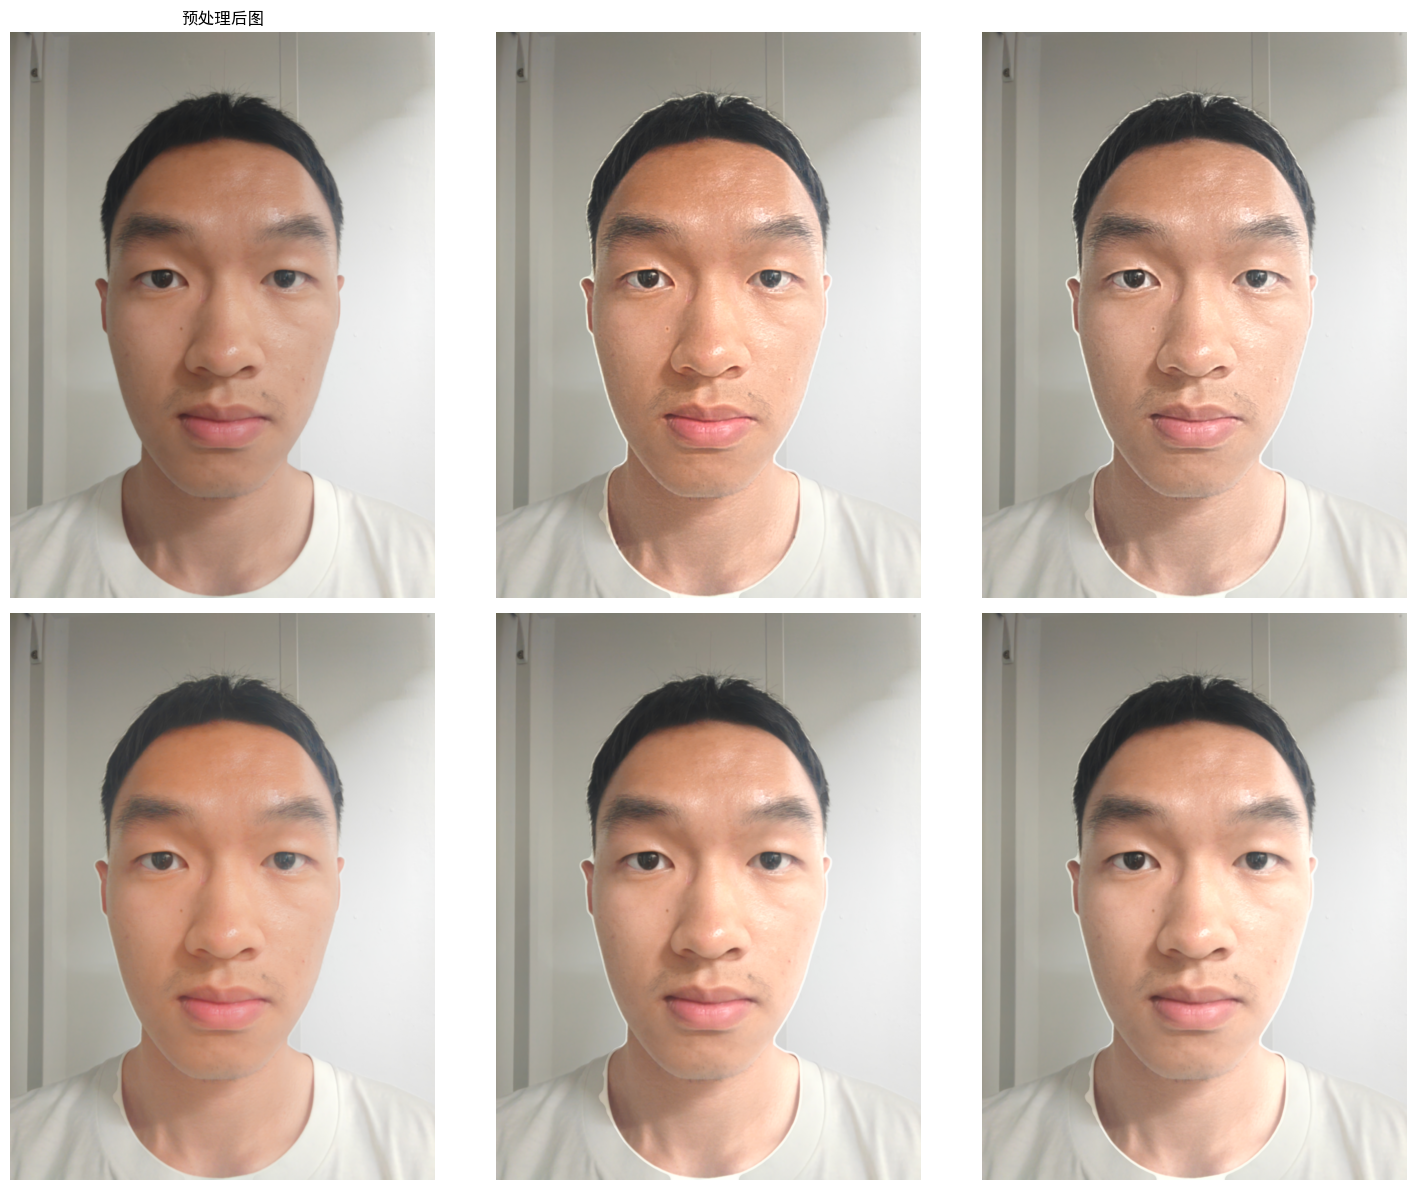

In [6]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("预处理后图")

img51 = whiten_hsi_clahe(
    img4, face_mask, clip_limit=2, tile_grid_size=(200, 200), k_size=21
)
plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(img51, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

img52 = whiten_lab_clahe(
    img4, face_mask, clip_limit=2, tile_grid_size=(200, 200), k_size=21
)
plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(img52, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

img53 = whiten_hsi_gamma(img4, face_mask, gamma=0.75, k_size=31)
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(img53, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

img54 = whiten_hsi_gain(img4, face_mask, gain_i=1.25, gain_s=0.9, k_size=31)
plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(img54, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

img55 = whiten_lab_gain(img4, face_mask, gain_l=1.25, gain_a=1.0, gain_b=1.0, k_size=31)
plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(img55, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

瘦脸。

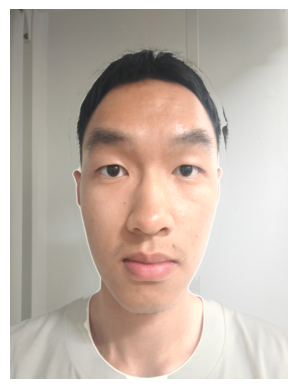

In [7]:
img6 = squeeze_face(img55, face_mask, gain=1.1)
plt.imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

大眼。

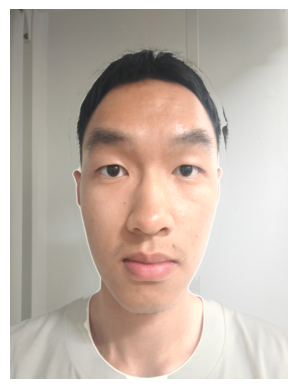

In [8]:
img7 = enlarge_eyes(img6, face_mask, gain=1.5, edge_low=5, edge_high=150, k_size=5)
plt.imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

磨皮。

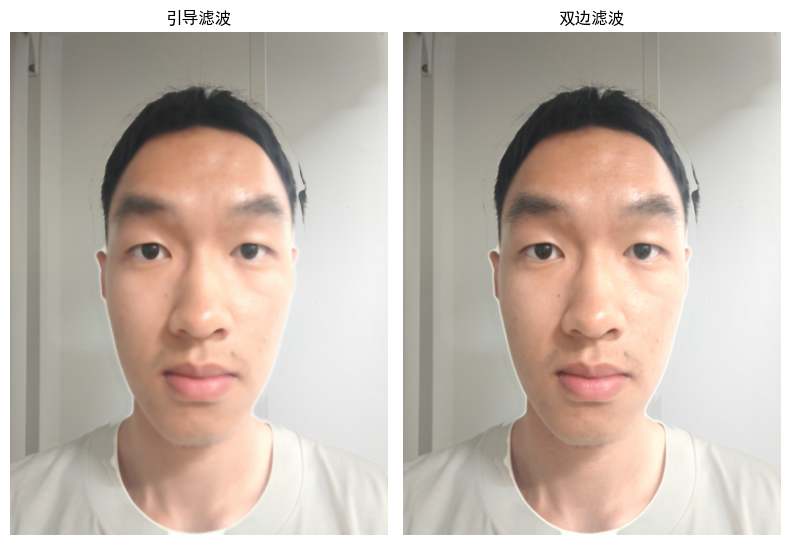

In [9]:
plt.figure(figsize=(8, 6))

img81 = smooth_skin_guided(img7, face_mask, radius=8, eps=0.01, k_size=11)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img81, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("引导滤波")

img82 = smooth_skin_bilateral(
    img7, face_mask, diameter=9, sigma_color=75, sigma_space=75, iterations=2, k_size=11
)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img82, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("双边滤波")

plt.tight_layout()
plt.show()

与原图像背景羽化融合。

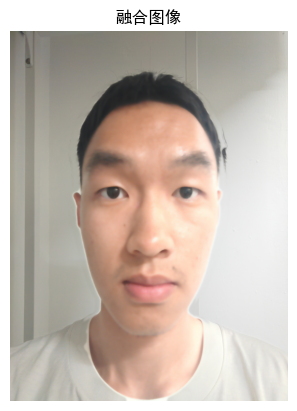

In [10]:
plt.figure()

alpha = feather_mask(face_mask, radius=15)
img9 = blend_image(img81, img0, alpha)
plt.imshow(cv2.cvtColor(img9, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("融合图像")
plt.show()